In [ ]:
# import packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk  
import tensorflow as tf
!pip install transformers
import torch

# BERT and T5 are easily imported from Hugging Face's transformer library (https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel
from transformers import BertTokenizer, TFBertModel, T5Tokenizer,  MT5Tokenizer, TFT5ForConditionalGeneration
from torch.utils.data import TensorDataset, random_split

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.utils import class_weight 


# Keras functional API
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers import SpatialDropout1D
from keras.layers import Input

import math

!pip install pyspellchecker  
from spellchecker import SpellChecker
  
import random
from random import randint
import more_itertools
from nltk import tokenize
nltk.download('punkt')

tf.test.gpu_device_name()

     |████████████████████████████████| 2.6 MB 10.2 MB/s 
     |████████████████████████████████| 636 kB 55.9 MB/s 
     |████████████████████████████████| 895 kB 56.9 MB/s 
     |████████████████████████████████| 3.3 MB 57.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


     |████████████████████████████████| 2.7 MB 7.8 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
# import transformers
#!pip install -q transformers

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test_set.tsv",sep='\t', encoding='ISO-8859-1')
dev = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/valid_set.tsv",sep='\t', encoding='ISO-8859-1')
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/training_set_rel3.tsv",sep='\t', encoding='ISO-8859-1')

In [ ]:
def clean_anonymization(essay):
  res=[]
  for i in essay.split():
    if i.startswith("@"):
      continue
    else:
      res.append(i)
  return ' '.join(res)

train['essay']=train['essay'].apply(lambda x:clean_anonymization(x))
# also remove from dev and test
dev['essay']=dev['essay'].apply(lambda x:clean_anonymization(x))
test['essay']=test['essay'].apply(lambda x:clean_anonymization(x))

In [ ]:
#based on the local coherence paper... randomly shuffling sentences within an essay.
def get_adversarial_local(df, examples):
  adv_essays = []
  random_examples = random.sample(range(0, len(df)), examples)
  for random_example in random_examples:
    b = df['sent'].iloc[random_example]
    if len(b) < 2:
      continue
    shuffled = sorted(b, key=lambda k: random.random())
    while shuffled == b:
      shuffled = sorted(b, key=lambda k: random.random())
    adv_essays.append(shuffled)
  return pd.Series(adv_essays)

In [ ]:
#based on the local coherence paper... randomly shuffling sentences within an essay.
def get_adversarial_global(df, examples):
  adv_essays = []
  random_examples = random.sample(range(0, len(df)), examples)
  for random_example in random_examples:
    b = df['sent'].iloc[random_example]
    if len(b) < 2:
      continue
    shuffled = sorted(b, key=lambda k: random.random())
    while shuffled == b:
      shuffled = sorted(b, key=lambda k: random.random())
    adv_essays.append(' '.join(shuffled))
  return pd.Series(adv_essays)

# Local Coherence 

based on 'A Neural Local Coherence Model', https://aclanthology.org/P17-1121.pdf

In [ ]:
def first_stage_model_local(hidden_size = 500, train_layers = -1, learning_rate= 3e-5, dropout_value=0.3):

    optimizer=tf.keras.optimizers.Adam(learning_rate)   

    """
    Build a simple classification model with BERT. Let's keep it simple and don't add dropout, layer norms, etc.
    """

    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                  'token_type_ids': token_type_ids,
                  'attention_mask': attention_mask}
    
    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False


    bert_out = bert_model(bert_inputs)

    classification_token = tf.keras.layers.Lambda(lambda x: x[:,0,:], name='get_first_vector')(bert_out[0])

    hidden = tf.keras.layers.Dense(hidden_size, name='hidden_layer')(classification_token)

    dropout = tf.keras.layers.Dropout(dropout_value)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(dropout)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], 
                                          outputs=[classification])
    
    classification_model.compile(optimizer=optimizer,
                            loss="mse",
                            metrics=["mae"])


    return classification_model

In [ ]:
def normalize(df):
    df['normalized_score'] = df['domain1_score'] / df.groupby('essay_set')['domain1_score'].transform('max')
    return df

def tokenized_test_local(df, examples):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    example = []
    window = 2
    for iteration in range(examples):
      sentences = df['sent'].iloc[iteration]
      if len(sentences) > window:
          window_list = list(more_itertools.windowed([k for k in range(len(sentences))],n=window, step=1))
      else:
          continue
      for hi in window_list:
        encoded_dict = tokenizer(sentences[hi[0]], sentences[hi[1]], 
                max_length=512,
                padding='max_length',
                truncation = True, 
                return_tensors='tf')

        example.append(df['essay_id'].iloc[iteration])
        input_ids.append(encoded_dict.input_ids)
        token_type_ids.append(encoded_dict.token_type_ids)
        attention_mask.append(encoded_dict.attention_mask)

    return {'input_ids': tf.concat([z for z in input_ids], axis=0), 'token_type_ids': tf.concat([z for z in token_type_ids], axis=0), 'attention_mask': tf.concat([z for z in attention_mask], axis=0), 'example': example}



In [ ]:
def tokenized_train_local(df, examples):
    example_iter = random.sample(range(0, len(df)-1), examples)
    example = []
    input_ids = []
    token_type_ids = []
    attention_mask = []
    gold_scores = []
    sentences_arr = []

    example_0 = []
    input_ids_0 = []
    token_type_ids_0 = []
    attention_mask_0 = []
    gold_scores_0 = []
    sentences_arr_0 = []

    window = 2
    for iteration in example_iter:
      sentences = df['sent'].iloc[iteration]
      if len(sentences) >= window:
          window_list = list(more_itertools.windowed([k for k in range(len(sentences))],n=window, step=1))
      else:
          continue
      for hi in window_list:
        encoded_dict = tokenizer(sentences[hi[0]], sentences[hi[1]], 
                max_length=512,
                padding='max_length', 
                truncation = True,
                return_tensors='tf')
        gold_scores.append(df['normalized_score'].iloc[iteration])
        sentences_arr.append(sentences)
        example.append(df['essay_id'].iloc[iteration])
        input_ids.append(encoded_dict.input_ids)
        token_type_ids.append(encoded_dict.token_type_ids)
        attention_mask.append(encoded_dict.attention_mask)

    examples_adv = get_adversarial_local(df, examples // 10)
    
    for example_adv in examples_adv:
      sentences = example_adv
      if len(sentences) >= window:
          window_list = list(more_itertools.windowed([k for k in range(len(sentences))],n=window, step=1))
      else:
          continue
      for hi in window_list:
        encoded_dict = tokenizer(sentences[hi[0]], sentences[hi[1]], 
                max_length=512,
                padding='max_length',
                truncation = True, 
                return_tensors='tf')
        gold_scores_0.append(0)
        sentences_arr_0.append(sentences)
        example_0.append('ADV')
        input_ids_0.append(encoded_dict.input_ids)
        token_type_ids_0.append(encoded_dict.token_type_ids)
        attention_mask_0.append(encoded_dict.attention_mask)

    total_sentences = sentences_arr + sentences_arr_0
    total_examples = example + example_0
    total_input_ids = input_ids + input_ids_0
    total_attention_masks = attention_mask + attention_mask_0
    total_token_type_ids = token_type_ids + token_type_ids_0
    total_gold_scores = gold_scores + gold_scores_0

 #   return [total_input_ids, total_token_type_ids, total_attention_masks, total_examples, total_gold_scores, total_sentences]

    return {'gold_scores': total_gold_scores, 'input_ids': tf.concat([z for z in total_input_ids], axis=0), 'token_type_ids': tf.concat([z for z in total_token_type_ids], axis=0), 'attention_mask': tf.concat([z for z in total_attention_masks], axis=0), 'example': total_examples}



In [ ]:
train = normalize(train)
train['sent'] = train['essay'].apply(lambda x: tokenize.sent_tokenize(x))
y = train['normalized_score']

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.33, random_state=0)
enc_train = tokenized_train_local(X_train, len(X_train) - 1)
enc_val = tokenized_train_local(X_test, len(X_test) - 1)
class_weights = class_weight.compute_class_weight('balanced',pd.Series(enc_train['gold_scores']).value_counts().index,pd.Series(enc_train['gold_scores']))
class_weights = dict(enumerate(class_weights))
fsm = first_stage_model_local()
fsm.fit([enc_train['input_ids'], enc_train['token_type_ids'], enc_train['attention_mask']], pd.Series(enc_train['gold_scores']), validation_data = ([enc_val['input_ids'], enc_val['token_type_ids'], enc_val['attention_mask']], pd.Series(enc_val['gold_scores'])) , epochs=1, batch_size=10, class_weight=class_weights, shuffle=True)


10851/10851 [==============================] - 8934s 822ms/step - loss: 0.0057 - mae: 0.1739 - val_loss: 0.0634 - val_mae: 0.1682


In [ ]:
enc_train = tokenized_test_local(train, len(train))
a = fsm.predict([enc_train['input_ids'], enc_train['token_type_ids'], enc_train['attention_mask']])

In [ ]:
res = pd.DataFrame(a)
res.index = enc_train['example'] # its important for comparison
res.columns = ["prediction"]
res.to_csv("local_coherence_results_train.csv")

(array([  245.,  1849.,  6512., 14826., 23647., 25298., 17262.,  6879.,
         1804.,   259.]),
 array([0.20959198, 0.2787954 , 0.34799883, 0.41720223, 0.48640567,
        0.5556091 , 0.6248125 , 0.6940159 , 0.76321936, 0.83242273,
        0.90162617], dtype=float32),
 <a list of 10 Patch objects>)

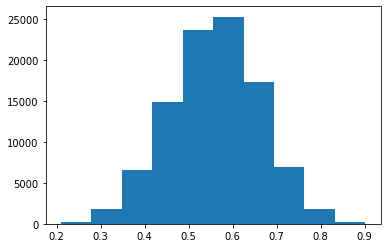

In [ ]:
plt.hist(a)

In [ ]:
res = pd.DataFrame(a)
res['essay_id'] = enc_test['example']
train_p = train.merge(res,on='essay_id',how='left')
train_p = train_p

ValueError: ignored

# Global coherence 
based on 'Automated Essay Scoring based on Two-Stage
Learning', https://arxiv.org/pdf/1901.07744v2.pdf


In [ ]:
def tokenized_train_global(df, examples):
    example_iter = random.sample(range(0, len(df)-1), examples)
    input_ids = []
    token_type_ids = []
    attention_mask = []
    gold_scores = []
    example = []

    input_ids_0 = []
    token_type_ids_0 = []
    attention_mask_0 = []
    gold_scores_0 = []
    example_0 = []

    for iteration in example_iter:
      essay = df['essay'].iloc[iteration]
      encoded_dict = tokenizer(essay, 
                max_length=512,
                padding='max_length',
                truncation = True, 
                return_tensors='tf')
      example.append(df['essay_id'].iloc[iteration])
      input_ids.append(encoded_dict.input_ids)
      token_type_ids.append(encoded_dict.token_type_ids)
      attention_mask.append(encoded_dict.attention_mask)
      gold_scores.append(df['normalized_score'].iloc[iteration])


    examples_adv = get_adversarial_global(df, examples // 10)
    
    for example_adv in examples_adv:
      essay = example_adv
      encoded_dict = tokenizer(essay, 
                max_length=512,
                padding='max_length',
                truncation = True, 
                return_tensors='tf')
      example_0.append(df['essay_id'].iloc[iteration])
      input_ids_0.append(encoded_dict.input_ids)
      token_type_ids_0.append(encoded_dict.token_type_ids)
      attention_mask_0.append(encoded_dict.attention_mask)
      gold_scores_0.append(0)

    total_examples = example + example_0
    total_input_ids = input_ids + input_ids_0
    total_attention_masks = attention_mask + attention_mask_0
    total_token_type_ids = token_type_ids + token_type_ids_0
    total_gold_scores = gold_scores + gold_scores_0

 #   return [total_input_ids, total_token_type_ids, total_attention_masks, total_examples, total_gold_scores, total_sentences]

    return {'gold_scores': total_gold_scores, 'input_ids': tf.concat([z for z in total_input_ids], axis=0), 'token_type_ids': tf.concat([z for z in total_token_type_ids], axis=0), 'attention_mask': tf.concat([z for z in total_attention_masks], axis=0), 'example': total_examples}



def tokenized_test_global(df, examples):
    example_iter = random.sample(range(0, len(df)), examples)
    input_ids = []
    token_type_ids = []
    attention_mask = []
    example = []
    for iteration in example_iter:
      essay = df['essay'].iloc[iteration]
      encoded_dict = tokenizer(essay, 
                max_length=512,
                padding='max_length',
                truncation = True, 
                return_tensors='tf')

      example.append(df['essay_id'].iloc[iteration])
      input_ids.append(encoded_dict.input_ids)
      token_type_ids.append(encoded_dict.token_type_ids)
      attention_mask.append(encoded_dict.attention_mask)
    
    return {'input_ids': tf.concat([z for z in input_ids], axis=0), 'token_type_ids': tf.concat([z for z in token_type_ids], axis=0), 'attention_mask': tf.concat([z for z in attention_mask], axis=0), 'example': example}

def normalize(df):
    df['normalized_score'] = df['domain1_score'] / df.groupby('essay_set')['domain1_score'].transform('max')
    return df


In [ ]:
def first_stage_model_global(hidden_size = 500, train_layers = -1, learning_rate= 1e-5, dropout_value=0.3):

    optimizer=tf.keras.optimizers.Adam(learning_rate)   

    """
    Build a simple classification model with BERT. Let's keep it simple and don't add dropout, layer norms, etc.
    """

    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                  'token_type_ids': token_type_ids,
                  'attention_mask': attention_mask}
    
    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False


    bert_out = bert_model(bert_inputs)

    classification_token = tf.keras.layers.Lambda(lambda x: x[:,0,:], name='get_first_vector')(bert_out[0])

    hidden = tf.keras.layers.Dense(hidden_size, name='hidden_layer')(classification_token)

    dropout = tf.keras.layers.Dropout(dropout_value)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(dropout)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], 
                                          outputs=[classification])
    
    classification_model.compile(optimizer=optimizer,
                            loss="mse",
                            metrics=["mae"])


    return classification_model

In [ ]:
train = normalize(train)
train['sent'] = train['essay'].apply(lambda x: tokenize.sent_tokenize(x))
y = train['normalized_score']

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.33, random_state=0)
enc_train = tokenized_train_global(X_train, len(X_train) - 1)
enc_val = tokenized_train_global(X_test, len(X_test) - 1)
class_weights = class_weight.compute_class_weight('balanced',pd.Series(enc_train['gold_scores']).value_counts().index,pd.Series(enc_train['gold_scores']))
class_weights = dict(enumerate(class_weights))
fsm = first_stage_model_global()
fsm.fit([enc_train['input_ids'], enc_train['token_type_ids'], enc_train['attention_mask']], pd.Series(enc_train['gold_scores']), validation_data = ([enc_val['input_ids'], enc_val['token_type_ids'], enc_val['attention_mask']], pd.Series(enc_val['gold_scores'])) , epochs=1, batch_size=10, class_weight=class_weights, shuffle=True)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
dev['sent'] = dev['essay'].apply(lambda x: tokenize.sent_tokenize(x))

enc_test = tokenized_test_global(train, len(train))
a = fsm.predict([enc_test['input_ids'], enc_test['token_type_ids'], enc_test['attention_mask']])

In [ ]:
res = pd.DataFrame(a)
res.index = enc_test['example'] # its important for comparison
res.columns = ["prediction"]
res.to_csv("global_coherence_results_train.csv")

#Hyperparameter Tuning - Local

In [ ]:
train = normalize(train)
y = train['normalized_score']
train['sent'] = train['essay'].apply(lambda x: tokenize.sent_tokenize(x))

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.33, random_state=0)
enc_train = tokenized_train_local(X_train, 500)
enc_val = tokenized_train_local(X_test, 500)
class_weights = class_weight.compute_class_weight('balanced',pd.Series(enc_train['gold_scores']).value_counts().index,pd.Series(enc_train['gold_scores']))
class_weights = dict(enumerate(class_weights))

dropout_values = [0.1,0.3,0.4,0.5]
hidden_sizes = [100,300, 500]
batch_sizes = [10]
learning_rates = [1e-5, 3e-5]
histories_local = {}
i = 0
for dropout_value in dropout_values:
  for hidden_size in hidden_sizes:
    for batch_size in batch_sizes:
      for learning_rate in learning_rates:
        print('\n' + 'iteration ' + str(i) + ' dropout_value: ' + str(dropout_value) + ' hidden_size: ' + str(hidden_size) + ' batch_size: ' + str(batch_size) + ' learning_rate ' + str(learning_rate) + "\n")
        fsm = first_stage_model(hidden_size=hidden_size, dropout_value=dropout_value, learning_rate=learning_rate)
        history = fsm.fit([enc_train['input_ids'], enc_train['token_type_ids'], enc_train['attention_mask']], pd.Series(enc_train['gold_scores']), validation_data = ([enc_val['input_ids'], enc_val['token_type_ids'], enc_val['attention_mask']], pd.Series(enc_val['gold_scores'])) , epochs=1, batch_size=batch_size, class_weight=class_weights, shuffle=True, verbose=2)
        histories_local[(dropout_value, hidden_size, batch_size, learning_rate)] = history.history['val_loss']
        i += 1


iteration 0 dropout_value: 0.1 hidden_size: 100 batch_size: 10 learning_rate 1e-05

593/593 - 574s - loss: 0.0089 - mae: 0.1822 - val_loss: 0.0681 - val_mae: 0.1817

iteration 1 dropout_value: 0.1 hidden_size: 100 batch_size: 10 learning_rate 3e-05

593/593 - 574s - loss: 0.0069 - mae: 0.1671 - val_loss: 0.0848 - val_mae: 0.2345

iteration 2 dropout_value: 0.1 hidden_size: 300 batch_size: 10 learning_rate 1e-05

593/593 - 575s - loss: 0.0032 - mae: 0.1156 - val_loss: 0.0688 - val_mae: 0.1848

iteration 3 dropout_value: 0.1 hidden_size: 300 batch_size: 10 learning_rate 3e-05

593/593 - 575s - loss: 0.0027 - mae: 0.1035 - val_loss: 0.0713 - val_mae: 0.1979

iteration 4 dropout_value: 0.1 hidden_size: 500 batch_size: 10 learning_rate 1e-05

593/593 - 574s - loss: 0.0018 - mae: 0.0809 - val_loss: 0.0671 - val_mae: 0.1830

iteration 5 dropout_value: 0.1 hidden_size: 500 batch_size: 10 learning_rate 3e-05

593/593 - 576s - loss: 0.0017 - mae: 0.0765 - val_loss: 0.0854 - val_mae: 0.2028

ite

KeyboardInterrupt: ignored

#Hyperparameter Tuning - Global

In [ ]:
train = normalize(train)
y = train['normalized_score']
train['sent'] = train['essay'].apply(lambda x: tokenize.sent_tokenize(x))


X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.33, random_state=0)
enc_train = tokenized_train_global(X_train, 1500)
enc_val = tokenized_train_global(X_test, 1500)
class_weights = class_weight.compute_class_weight('balanced',pd.Series(enc_train['gold_scores']).value_counts().index,pd.Series(enc_train['gold_scores']))
class_weights = dict(enumerate(class_weights))

dropout_values = [0.1,0.3,0.5]
hidden_sizes = [100,300, 500]
batch_sizes = [10]
learning_rates = [1e-5, 3e-5]
histories_global = {}
i = 0
for dropout_value in dropout_values:
  for hidden_size in hidden_sizes:
    for batch_size in batch_sizes:
      for learning_rate in learning_rates:
        print('\n' + 'iteration ' + str(i) + ' dropout_value: ' + str(dropout_value) + ' hidden_size: ' + str(hidden_size) + ' batch_size: ' + str(batch_size) + ' learning_rate ' + str(learning_rate) + "\n")
        fsm = first_stage_model(hidden_size=hidden_size, dropout_value=dropout_value, learning_rate=learning_rate)
        history = fsm.fit([enc_train['input_ids'], enc_train['token_type_ids'], enc_train['attention_mask']], pd.Series(enc_train['gold_scores']), validation_data = ([enc_val['input_ids'], enc_val['token_type_ids'], enc_val['attention_mask']], pd.Series(enc_val['gold_scores'])) , epochs=2, batch_size=batch_size, class_weight=class_weights, shuffle=True, verbose=2)
        histories_global[(dropout_value, hidden_size, batch_size, learning_rate)] = history.history['val_loss']
        i += 1


iteration 0 dropout_value: 0.1 hidden_size: 100 batch_size: 10 learning_rate 1e-05

Epoch 1/2
187/187 - 193s - loss: 0.0124 - mae: 0.2461 - val_loss: 0.0807 - val_mae: 0.2138
Epoch 2/2
187/187 - 175s - loss: 0.0098 - mae: 0.2160 - val_loss: 0.0645 - val_mae: 0.1934

iteration 1 dropout_value: 0.1 hidden_size: 100 batch_size: 10 learning_rate 3e-05

Epoch 1/2
187/187 - 193s - loss: 0.0093 - mae: 0.2136 - val_loss: 0.0550 - val_mae: 0.1767
Epoch 2/2
187/187 - 175s - loss: 0.0045 - mae: 0.1436 - val_loss: 0.0636 - val_mae: 0.1896

iteration 2 dropout_value: 0.1 hidden_size: 300 batch_size: 10 learning_rate 1e-05

Epoch 1/2
187/187 - 193s - loss: 0.0033 - mae: 0.1206 - val_loss: 0.0494 - val_mae: 0.1603
Epoch 2/2
187/187 - 175s - loss: 0.0017 - mae: 0.0887 - val_loss: 0.0433 - val_mae: 0.1487

iteration 3 dropout_value: 0.1 hidden_size: 300 batch_size: 10 learning_rate 3e-05

Epoch 1/2
187/187 - 192s - loss: 0.0024 - mae: 0.1023 - val_loss: 0.0740 - val_mae: 0.2014
Epoch 2/2
187/187 - 175

In [ ]:
h = pd.DataFrame.from_dict(histories_global)
h.to_csv('tuning_global_coherence.csv')

In [ ]:
histories_global

{(0.1, 100, 10, 1e-05): [0.08068609237670898, 0.0644613653421402],
 (0.1, 100, 10, 3e-05): [0.05495355278253555, 0.06363699585199356],
 (0.1, 300, 10, 1e-05): [0.0493742972612381, 0.04325374588370323],
 (0.1, 300, 10, 3e-05): [0.07398101687431335, 0.04345472529530525],
 (0.1, 500, 10, 1e-05): [0.044093597680330276, 0.041312314569950104],
 (0.1, 500, 10, 3e-05): [0.048979777842760086, 0.07125916332006454],
 (0.3, 100, 10, 1e-05): [0.0444457083940506, 0.04388219863176346],
 (0.3, 100, 10, 3e-05): [0.05134948715567589, 0.05273989215493202],
 (0.3, 300, 10, 1e-05): [0.04527990147471428, 0.04478912428021431],
 (0.3, 300, 10, 3e-05): [0.04559430107474327, 0.05699139088392258],
 (0.3, 500, 10, 1e-05): [0.04162762314081192, 0.04069681465625763],
 (0.3, 500, 10, 3e-05): [0.04492127150297165, 0.042551424354314804],
 (0.5, 100, 10, 1e-05): [0.04075055569410324, 0.04354342445731163],
 (0.5, 100, 10, 3e-05): [0.05068989098072052, 0.05174487456679344],
 (0.5, 300, 10, 1e-05): [0.047663651406764984, 